# カリフォルニアの各地区の住宅価格を予測する

## データ
https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

1990年のアメリカ国勢調査によって作成されたデータ。  
1行はブロックを指し、ブロックとは最小の地区の単位を指す。  
通常ブロックには600人から3,000人の人口がある。  

## 詳細

MedInc: 収入中央値  
HouseAge: 築年数中央値  
AveRooms: 世帯あたりの部屋数  
AveBedrms: 世帯あたりの寝室数  
Population: ブロック内の人口  
AveOccup: 平均世帯人数  
Latitude: 緯度  
Longitude: 経度  
price: 価格。単位は10万ドル（これを推測したい）  

世帯数が大きなブロックの場合、保養地などの空き家である可能性もあり大きな数字となる場合がある。

目的変数：今回は価格。最終的に推測したい変量  
説明変数：目的変数以外の変量

In [2]:
# パッケージ読み込み

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
# EDA.
# 訓練用データの説明、目的変数を結合して、分析を行う。
df = pd.DataFrame(fetch_california_housing().data, columns = fetch_california_housing().feature_names)
df["price"] = fetch_california_housing().target

print(df.dtypes) #型の確認
df.head() # 先頭を確認

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
price         float64
dtype: object


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
# 欠損値の確認
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
price         0
dtype: int64

<Axes: xlabel='Longitude', ylabel='Latitude'>

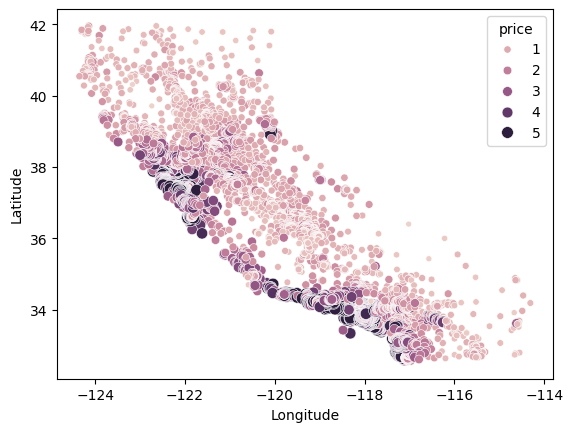

In [5]:
# 緯度経度データがあるので可視化してみる
sns.scatterplot(data=df, y="Latitude", x="Longitude", size="price", hue="price")

なんとなく左に偏りがあることがわかる。  
下の地図と比較すると、東海岸の家賃が高いことがわかる。

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://amview.japan.usembassy.gov/wp-content/uploads/2016/04/CA-State-Major-Cities-e1459733069584.jpg")

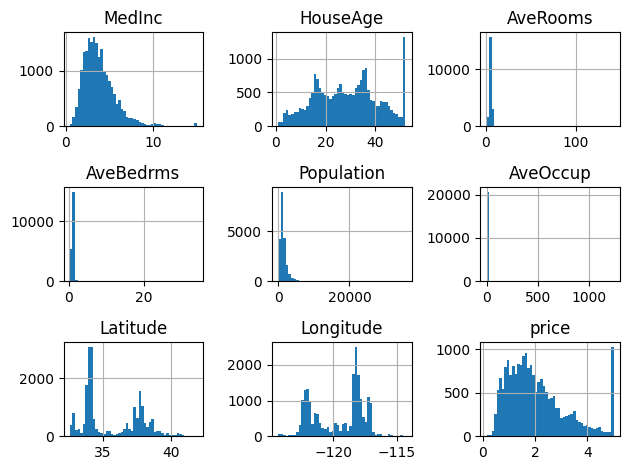

In [6]:
# 分布の確認

df.hist(bins=50)
plt.tight_layout()
plt.show()

収入（左上）と価格（右下）は右裾に長い分布  
築年数はいくつかの分布が重なっているようにも見えるが、正規分布に近しいとも言える  
部屋数、寝室数、人口、世帯人数（右上から右中）には極端に数値が大きい外れ値がありそう。  
Latm Longは地理的要因なので気にしない  

In [6]:
# 記述統計
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


AveRooms, AveBedrms, Population, AveOccupの4つについて、minと25%の間、25%と50%の間、50%と75%の間、75%とmaxの間を確認してみる。　　

例えばAveRoomsについては25%,50%,75%の間は1程度の変化だが、minと25%の間は3, 75%とmaxの間は138となっており、上側に極端な外れ値があることがわかる。

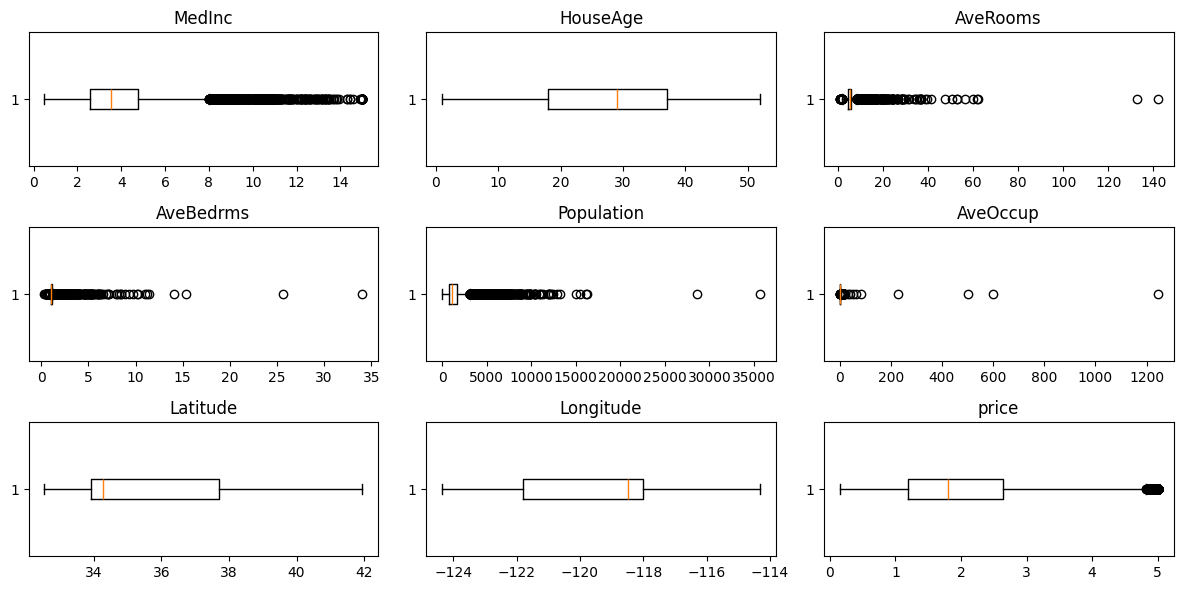

In [8]:
# 箱ひげ図の確認
cols = df.columns
fig, ax = plt.subplots(len(cols)//3, 3, figsize=(12,6))
ax = ax.flatten()
for i, col in enumerate(cols):
    ax[i].boxplot(df[col],vert=False)
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

部屋数と寝室数は外れ値が多すぎてよくわからない

<Axes: >

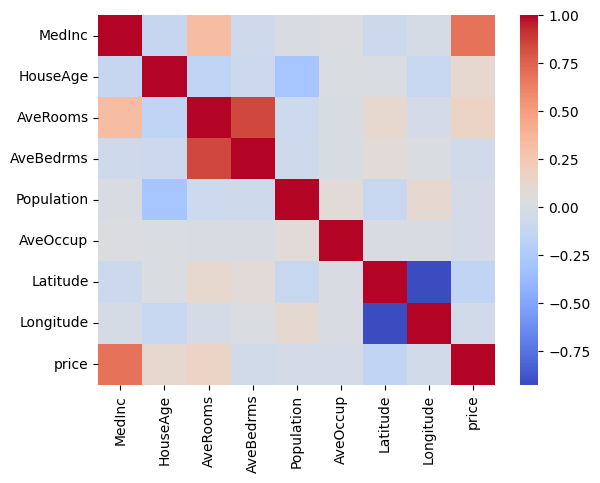

In [18]:
# 相関を確認してみる
sns.heatmap(df.corr(), cmap="coolwarm")

正の相関  （>0.7）  
収入（MedInc）と住宅価格（price）  
部屋数と寝室数

負の相関（<-0.7）  
緯度経度→地形的な話なので興味なし

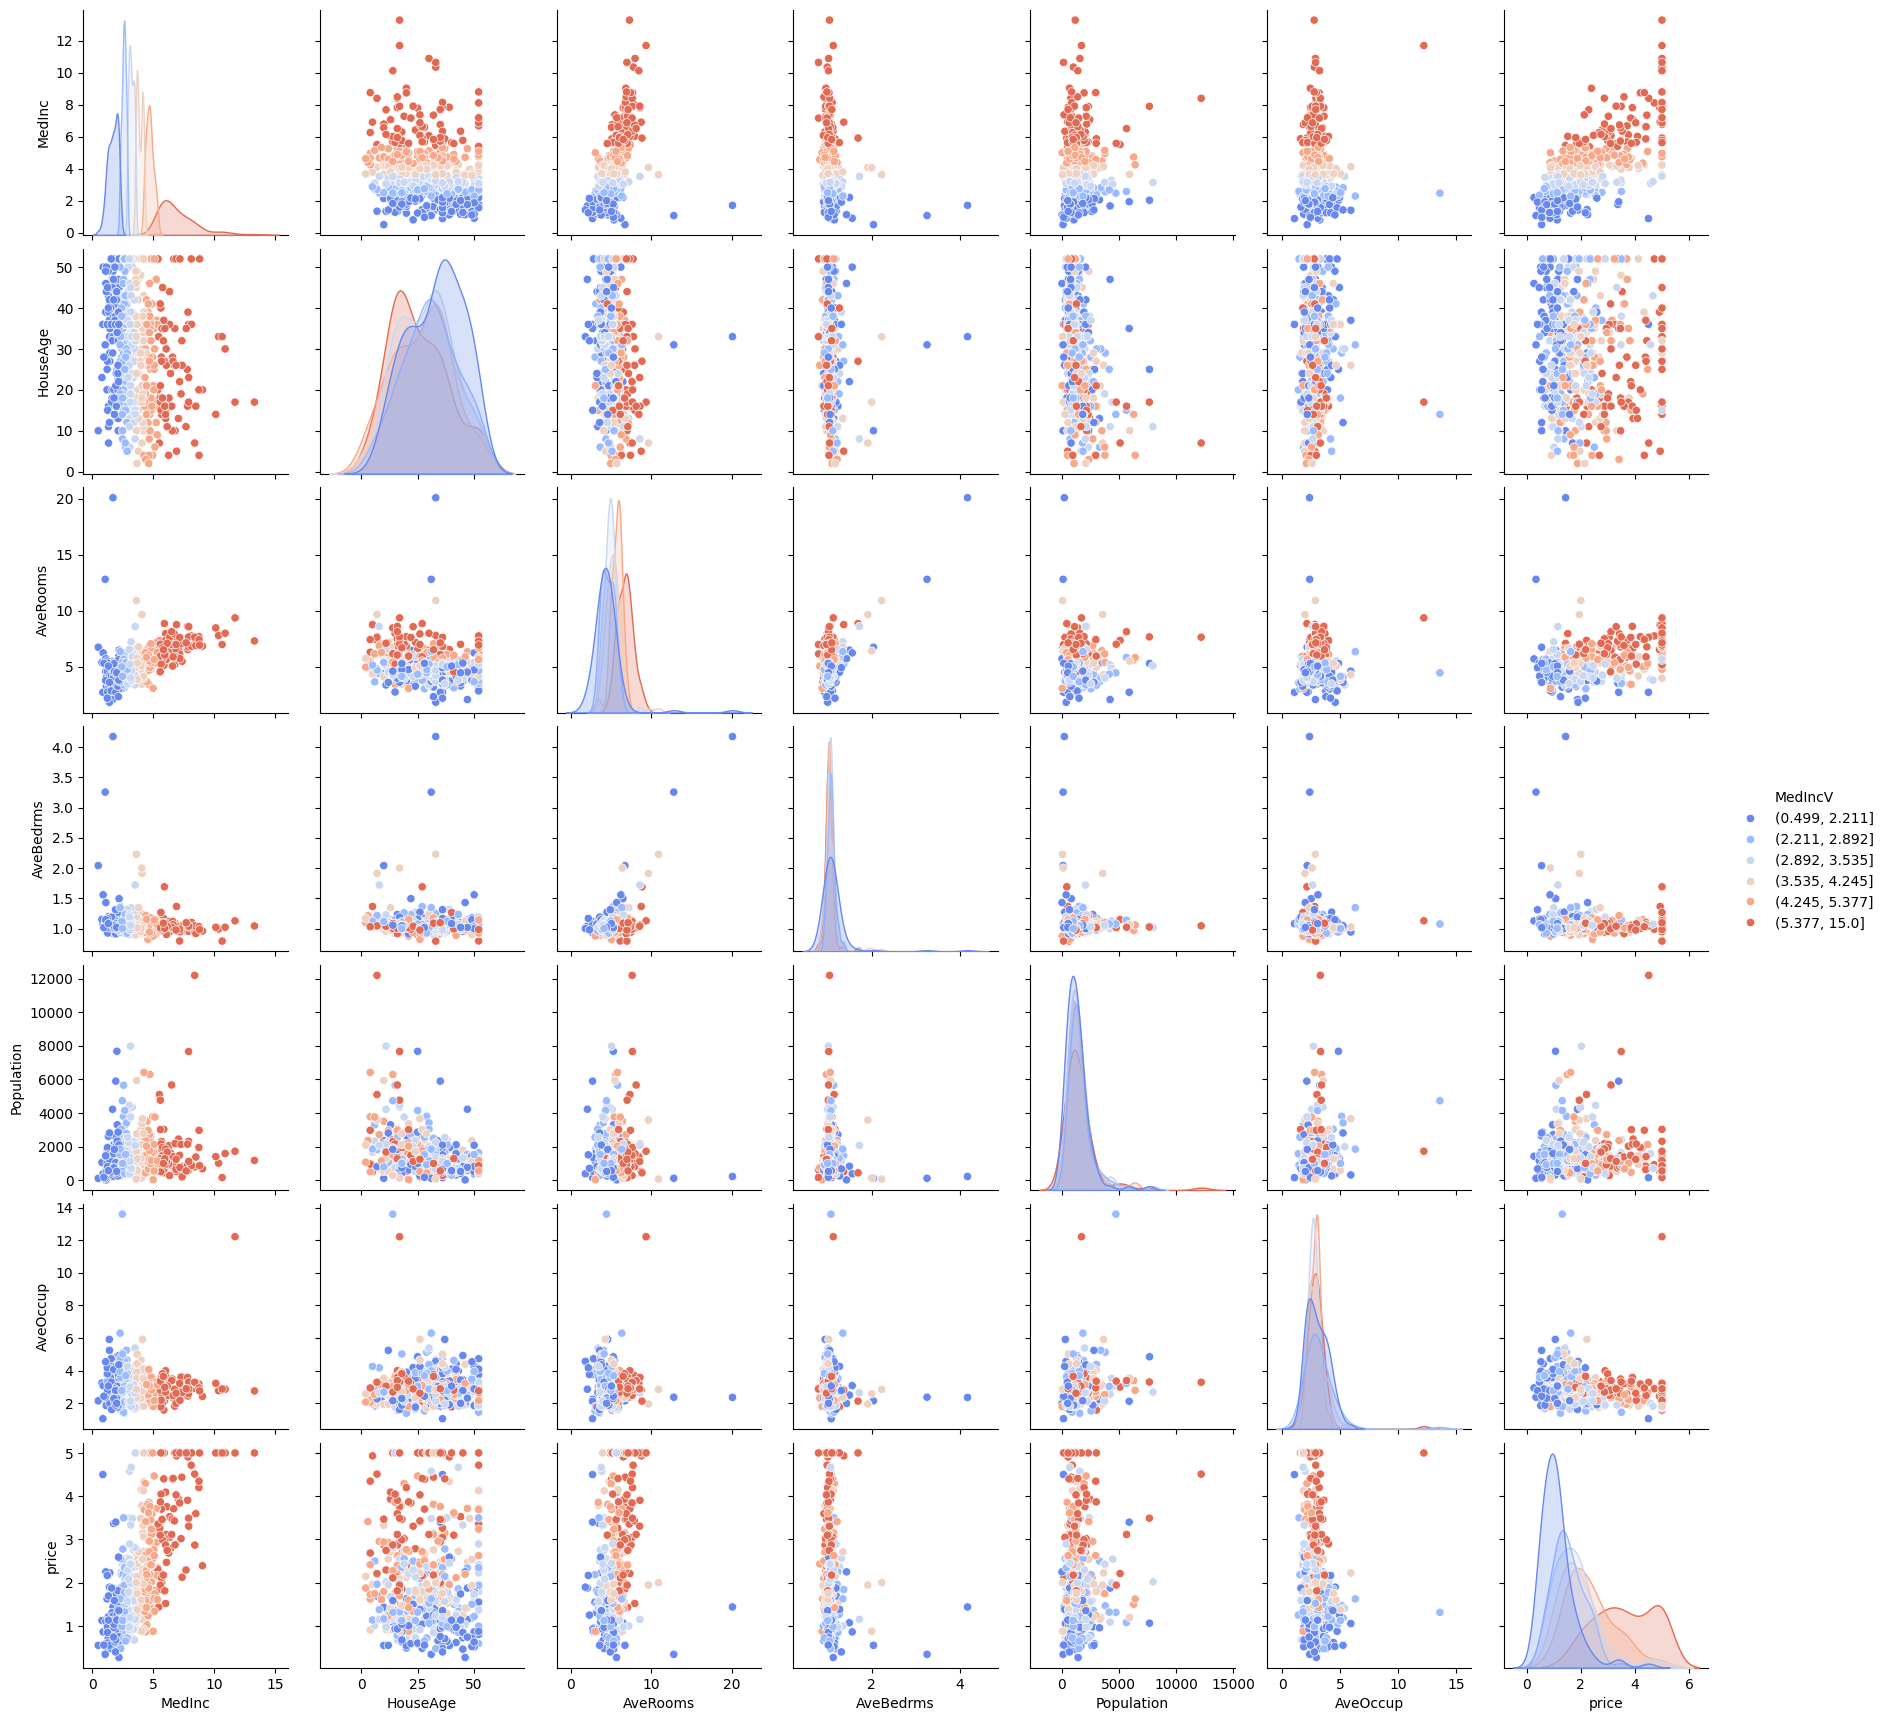

In [8]:
# 収入ごとに散布図を書く

plot_cols = df.columns.to_list()
plot_cols.remove("Latitude")
plot_cols.remove("Longitude")

s = df.copy()[plot_cols]

# 収入の値を6つに分割
s["MedIncV"] = pd.qcut(s["MedInc"], 6, retbins=False)

# sns.pairplot(s, hue="MedIncV") # 重すぎる
sns.pairplot(s.sample(500, random_state=12), hue="MedIncV", palette="coolwarm") #全数表示は重すぎるのでランダムサンプリング

部屋数、寝室数、人口、世帯人数には極端な外れ値を確認できる。   

築年数の分布には2つの山があることがわかる（おそらく低所得者ほど古い家に住んでいる）